### Importing The Packages

In [1]:
# Importing the liabraries
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.utils import to_categorical
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import cv2
from tqdm import tqdm
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,f1_score,ConfusionMatrixDisplay
import os
import pandas as pd
import pickle

# if you dont have cuda enabled gpu in your system comment the lines below
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-01-13 02:30:57.552290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-13 02:30:57.723349: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-13 02:30:58.512178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/aamiz_z/miniconda3/envs/fvgpu/lib/:/home/aamiz_z/miniconda3/envs/fvgpu/lib/python3.10/site-packages/nvidia/cudnn/lib
2024-01-13 02:30:58.512360: W tensorflow/stream_executor/platform/default/dso_loader.cc:

Num GPUs Available:  1


2024-01-13 02:30:59.287889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-13 02:30:59.317070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-13 02:30:59.317281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Loading the dataset

In [2]:
# loading the datas
images = []
labels = []
# Location with subdirectories
path = "/home/aamiz_z/Desktop/joud/preprocessed_images_40"
# Get List of all images
png_files = glob.glob(path + '/**/*.png', recursive=True)
jpg_files = glob.glob(path + '/**/*.png', recursive=True)

files = png_files+jpg_files
# For each image
for file in  tqdm (files):
    img = cv2.imread(file)[:,:,::-1]
    img = cv2.resize(img,(224,224))
    img = img/255
    #print(filename)
    images.append(img)
    y = file.split('/')[-2]
    #print(y)
    labels.append(y)
images = np.array(images)
labels = np.array(labels)

100%|████████████████████████████████████████| 896/896 [00:01<00:00, 693.95it/s]


### Data Analysis

In [3]:
# shape of images
print("Shape of Data = ", images.shape)

Shape of Data =  (896, 224, 224, 3)


In [4]:
print("Shape of labels = ", labels.shape)

Shape of labels =  (896,)


labels
mild      440
severe    328
normal    128
Name: count, dtype: int64


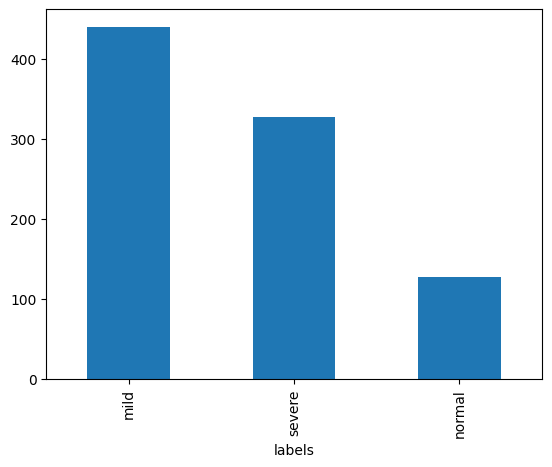

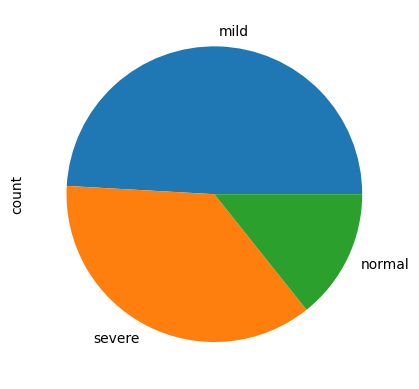

In [5]:
# storing the labels in the data frame
labels_df = pd.DataFrame(labels,columns=['labels'])

print(labels_df['labels'].value_counts())
plt.figure()
labels_df['labels'].value_counts().plot.bar()
plt.show()
plt.figure()
labels_df['labels'].value_counts().plot.pie()
plt.show()

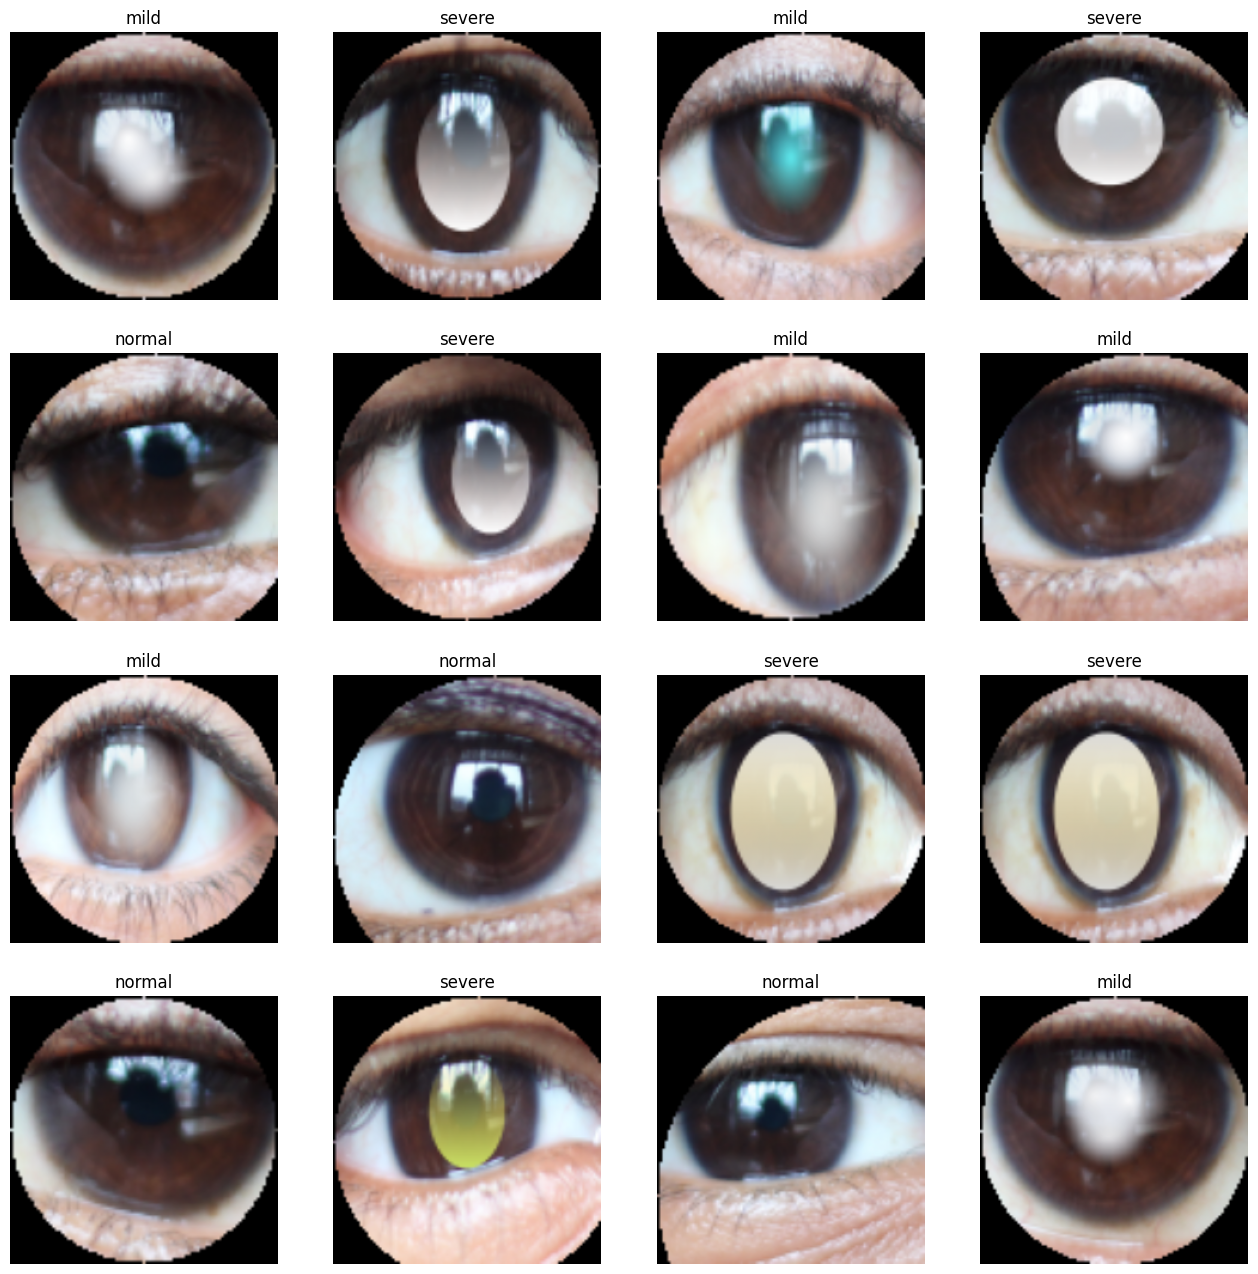

In [6]:
# This code will help you in visualizing mages
#np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, images.shape[0], 1))
    plt.title(str(labels[index]))
    plt.imshow(images[index])
    plt.axis('off')

In [7]:
# loabel encoding of categorical features
le = LabelEncoder()
labels = le.fit_transform(labels)

# one hot encoding to feed it into model.
labels =to_categorical(labels)

# Save the classes to a pickle file
pickle_file_path = 'label_encoder_classes.pkl'
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(le.classes_, pickle_file)

print(f"LabelEncoder classes saved to {pickle_file_path}")

LabelEncoder classes saved to label_encoder_classes.pkl


In [8]:
#### Splitting the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)


### Deep Learning Models


In [9]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
accuracy_loss_plot = PlotLearning()

### Model 1 CNN

In [10]:
#the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

2024-01-13 02:31:03.392133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-13 02:31:03.393171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-13 02:31:03.393459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-13 02:31:03.393639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [11]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

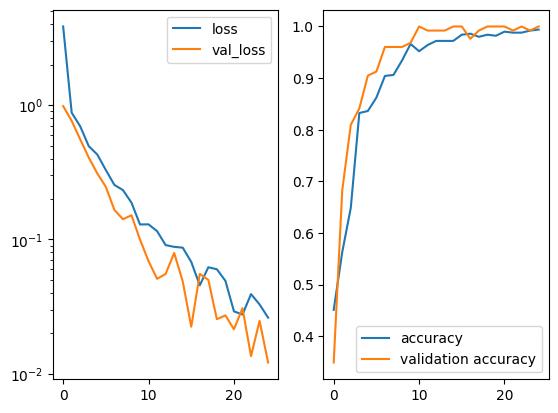

16/16 [==============================] - 2s 122ms/step - loss: 0.0262 - accuracy: 0.9940 - val_loss: 0.0121 - val_accuracy: 1.0000


In [12]:
#train the model with min batch size as 32 
history=model.fit(X_train,y_train,validation_split=0.2,epochs=25,batch_size=32, callbacks=accuracy_loss_plot)

#### Model Evaluation

In [13]:
### train performace 

In [14]:
y_pred = model.predict(X_train,batch_size=32)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

20/20 [==============================] - 1s 34ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00        96
           2       1.00      1.00      1.00       230

    accuracy                           1.00       627
   macro avg       1.00      1.00      1.00       627
weighted avg       1.00      1.00      1.00       627



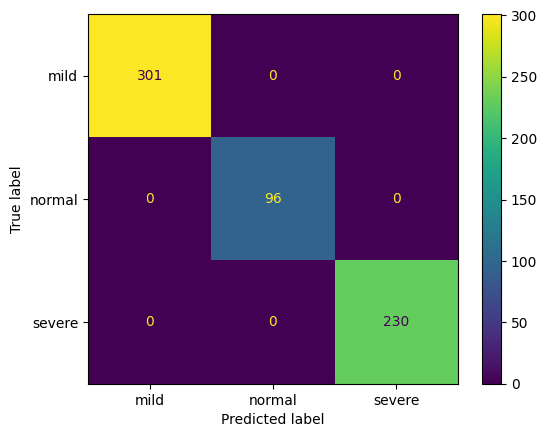

In [15]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [16]:
### test performace 

In [17]:
# get model predictions
y_pred = model.predict(X_test,batch_size=32)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


9/9 [==============================] - 0s 41ms/step


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       139
           1       1.00      1.00      1.00        32
           2       0.98      0.96      0.97        98

    accuracy                           0.98       269
   macro avg       0.98      0.98      0.98       269
weighted avg       0.98      0.98      0.98       269



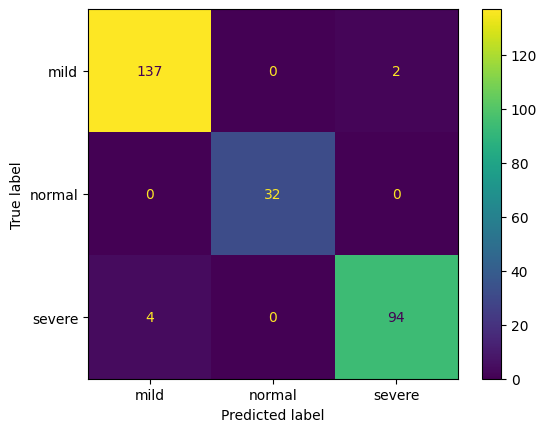

In [18]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [19]:
### save the model
model.save('cnn_mode.h5')

In [20]:
del(model)

### VGG 16

In [21]:
### initializing the model 
base_model = VGG16(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(3, activation= 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 14,848,835
Trainable params: 133,123
Non-trainable params: 14,715,712
____________________________________

In [22]:
### compiling the model
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

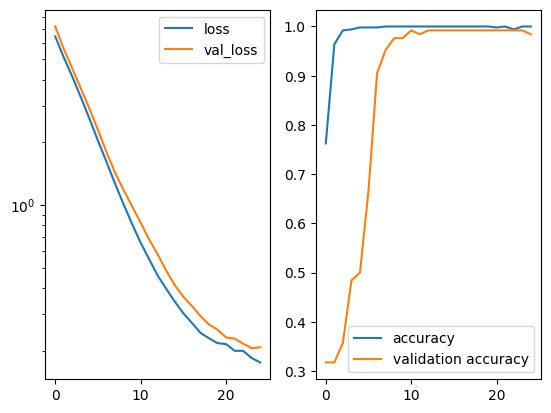

16/16 [==============================] - 6s 355ms/step - loss: 0.1758 - accuracy: 1.0000 - val_loss: 0.2079 - val_accuracy: 0.9841


In [23]:
history=model.fit(X_train,y_train,batch_size=32,validation_split=0.2,epochs=25,callbacks=accuracy_loss_plot)

In [24]:
### train performance

In [25]:
y_pred = model.predict(X_train,batch_size=32)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

20/20 [==============================] - 7s 355ms/step


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       301
           1       1.00      0.99      0.99        96
           2       1.00      1.00      1.00       230

    accuracy                           1.00       627
   macro avg       1.00      1.00      1.00       627
weighted avg       1.00      1.00      1.00       627



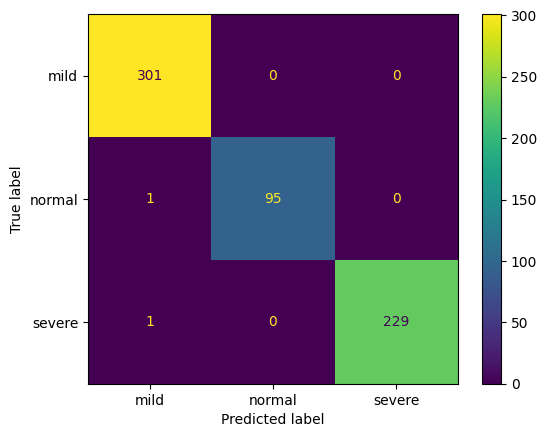

In [26]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [27]:
### test performace 

In [28]:
# get model predictions
y_pred = model.predict(X_test,batch_size=32)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


9/9 [==============================] - 3s 430ms/step


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       139
           1       0.94      0.97      0.95        32
           2       1.00      0.99      0.99        98

    accuracy                           0.99       269
   macro avg       0.98      0.98      0.98       269
weighted avg       0.99      0.99      0.99       269



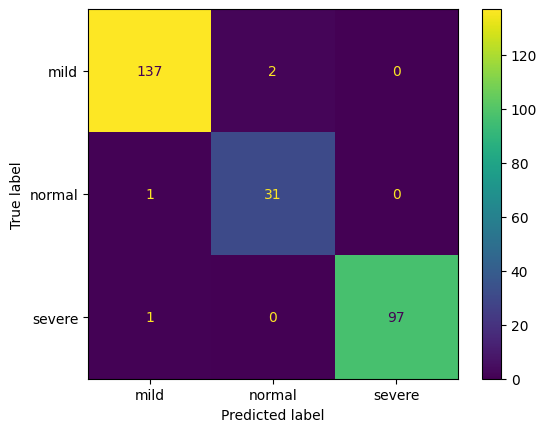

In [29]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [30]:
### save the model
model.save('vgg_model.h5')

In [31]:
del(model)